## VIVEK BHAVSHAR
## Neural Network - LSTM, RNN
## Time Series Forecasting for Weather Prediction

## Importing important libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequentialfrom sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
#choosing AEP_hourly.csv data for analysis

file=("C:/Users/VIVEK/Documents/CSC 425 Time series final project/PJME_hourly.csv")

#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data

df=pd.read_csv(file, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
#checking missing data
df.isna().sum()

PJME_MW    0
dtype: int64

### Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

## Data visualization

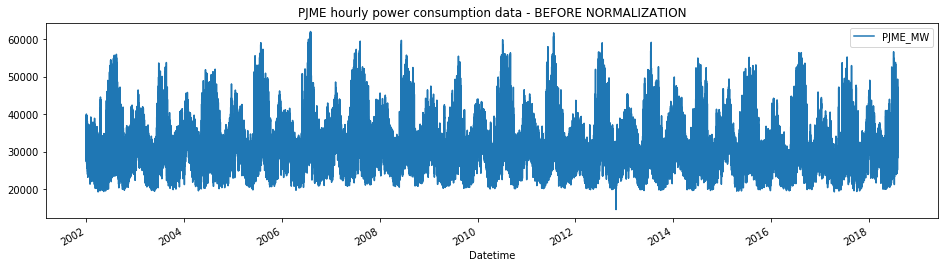

In [5]:
#Data visualization

df.plot(figsize=(16,4),legend=True)

plt.title('PJME hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

## Normalize data
Before proceeding with further data analysis we must ensure that the data is normalized. For this we will be using sklearn MinMaxScaler

In [6]:
#Normalize PJME hourly power consumption data
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(145366, 1)

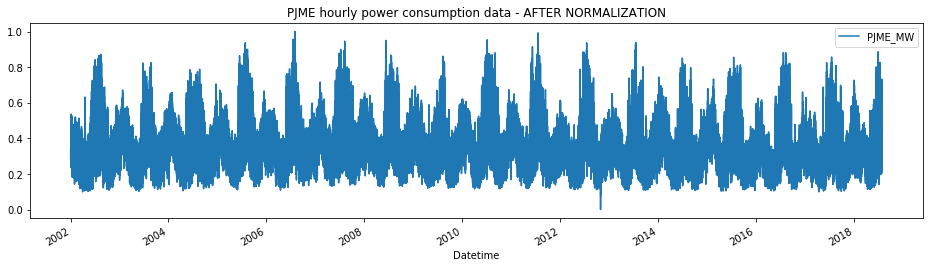

In [7]:
#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('PJME hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [8]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 29,074 days are going to be used in test
    X_test = X_train[116292:]
    y_test = y_train[116292:]

    # 2 first 116292 days are going to be used in training
    X_train = X_train[:116292]
    y_train = y_train[:116292]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (116292, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]


In [9]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (116292, 20, 1)
y_train.shape =  (116292,)
X_test.shape =  (29054, 20, 1)
y_test.shape =  (29054,)


In [10]:
#RNN model

rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [11]:
#model compile
rnn_model.compile(optimizer="adam",loss="MSE")
#model fit
model1 = rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
116292/116292 [==============================] - 21s 184us/step - loss: 0.10811s - loss:
Epoch 2/10
116292/116292 [==============================] - 20s 175us/step - loss: 0.02012
Epoch 3/10
116292/116292 [==============================] - 20s 175us/step - loss: 0.0105
Epoch 4/10
116292/116292 [==============================] - 20s 171us/step - loss: 0.0072
Epoch 5/10
116292/116292 [==============================] - 20s 171us/step - loss: 0.0054
Epoch 6/10
116292/116292 [==============================] - 20s 174us/step - loss: 0.0044
Epoch 7/10
116292/116292 [==============================] - 20s 174us/step - loss: 0.00370s - loss: 
Epoch 8/10
116292/116292 [==============================] - 18s 158us/step - loss: 0.00321s - loss
Epoch 9/10
116292/116292 [==============================] - 20s 176us/step - loss: 0.0028
Epoch 10/10
116292/116292 [==============================] - 20s 174us/step - loss: 0.0025


In [45]:
# function for plotting difference between training and validation model loss
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.title('Training model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plt.show()

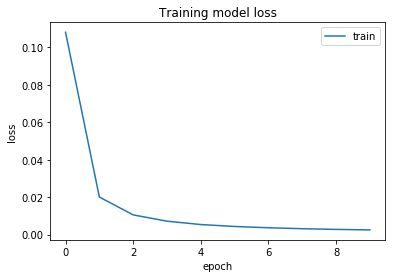

In [46]:
plotLosses(model1)

In [14]:
#r2 score for the values predicted by the above trained SIMPLE RNN model

rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9692839409485616


In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_test, rnn_predictions))
print("RMSE Score of RNN model = ",rms)

RMSE Score of RNN model =  0.02410749347567785


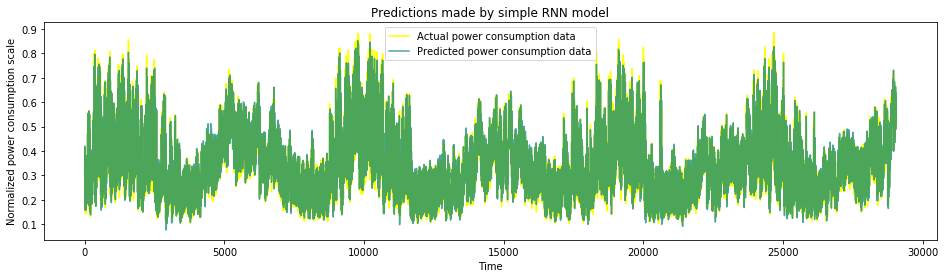

In [15]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='yellow', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='teal', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()


plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")


In [16]:
#train model for LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [17]:
# model compilation 
lstm_model.compile(optimizer="adam",loss="MSE")

# model fit
model2 = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
116292/116292 [==============================] - 64s 548us/step - loss: 0.0220
Epoch 2/10
116292/116292 [==============================] - 60s 518us/step - loss: 0.0116
Epoch 3/10
116292/116292 [==============================] - 61s 522us/step - loss: 0.0054
Epoch 4/10
116292/116292 [==============================] - 61s 523us/step - loss: 0.0039
Epoch 5/10
116292/116292 [==============================] - 61s 523us/step - loss: 0.0027
Epoch 6/10
116292/116292 [==============================] - 62s 530us/step - loss: 0.0021
Epoch 7/10
116292/116292 [==============================] - 60s 519us/step - loss: 0.0018
Epoch 8/10
116292/116292 [==============================] - 60s 519us/step - loss: 0.0016
Epoch 9/10
116292/116292 [==============================] - 61s 523us/step - loss: 0.0015
Epoch 10/10
116292/116292 [==============================] - 61s 524us/step - loss: 0.0014


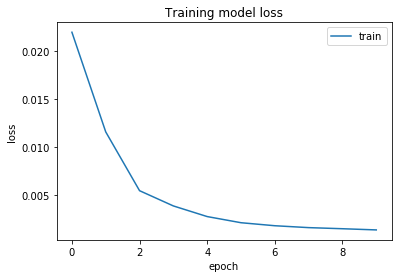

In [47]:
plotLosses(model2)

In [19]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9736259662101764


In [43]:
rms1 = sqrt(mean_squared_error(y_test, lstm_predictions))
print("RMSE Score of RNN model = ",rms1)

RMSE Score of RNN model =  0.022338684278129448


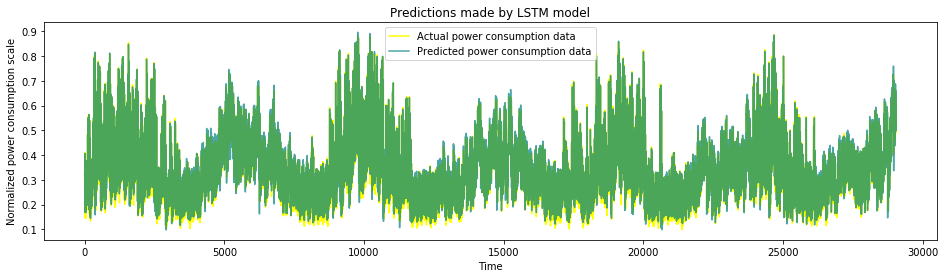

In [20]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

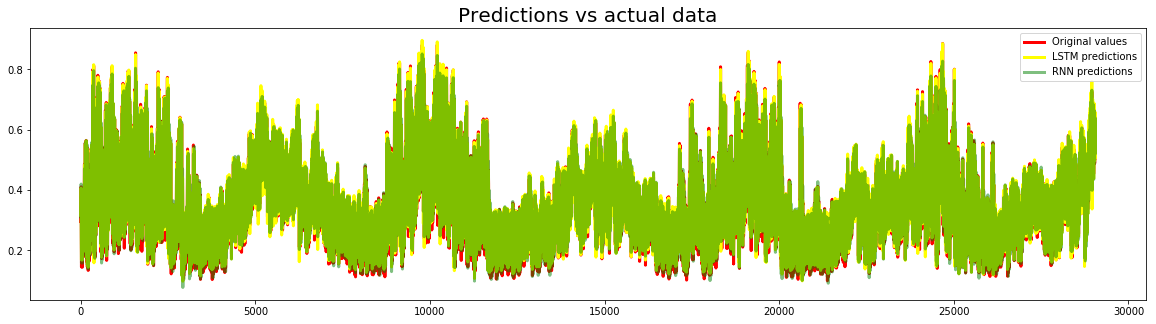

In [49]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(20,5))

plt.plot(y_test, c="red", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="yellow", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()